In [60]:
from copy import deepcopy
from dataclasses import dataclass
from random import choice, sample
from statistics import mean
from time import perf_counter
from typing import Callable

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display

plt.rcParams['figure.figsize'] = (16, 12)
sns.set_theme(style="darkgrid")


In [61]:
df_a = pd.read_csv("data/TSPA.csv", sep=";", header=None, names=["x", "y", "cost"])
df_b = pd.read_csv("data/TSPB.csv", sep=";", header=None, names=["x", "y", "cost"])


In [62]:
df_a = df_a.loc[[27, 59, 96, 116, 143, 147, 159]].reset_index(drop=True)

In [63]:
df_b

,x,y,cost
0,2907,1115,928
1,3433,183,1864
2,2237,74,260
3,91,583,1006
4,3053,1867,993
...,...,...,...
195,1252,970,1882
196,613,784,439
197,3139,470,597
198,2465,1165,570


# Problem:
 1. Select 50% of nodes and form a Hamiltonian cycle.
 2. The sum of the total length of the path plus the total cost of the selected nodes should be minimized.

In [64]:
class Node:
    def __init__(self, id, x, y, cost) -> None:
        self.id = id
        self.x = x
        self.y = y
        self.cost = cost
        self.connections: list[Node] = []

    def add_connection(self, node: "Node") -> None:
        self.connections.append(node)
        node.connections.append(self)

    def remove_connection(self, node: "Node") -> None:
        self.connections.remove(node)
        node.connections.remove(self)

    def __eq__(self, o: object) -> bool:
        if isinstance(o, Node):
            return self.id == o.id

        return False
    
    def __hash__(self) -> int:
        return self.id

    def __repr__(self) -> str:
        return (
            f"\n{' Node ':=^80}"
            f"\n{'id:':<40}{self.id}"
            f"\n{'x:':<40}{self.x}"
            f"\n{'y:':<40}{self.y}"
            f"\n{'cost:':<40}{self.cost}"
            f"\n{'':=^80}\n"
        )

    def __str__(self) -> str:
        return str(self.id)

In [65]:
nodes = [Node(i, x, y, cost) for i, (x, y, cost) in enumerate(zip(df_a.x, df_a.y, df_a.cost))]

In [66]:
# Check if the nodes are unique
len(set(nodes)) == len(nodes)

True

In [67]:
def _euclidean_distance(a: Node, b: Node) -> float:
    return round(((a.x - b.x) ** 2 + (a.y - b.y) ** 2) ** 0.5)

```
algorithm random is
    input: Pivot node pn,
           List of nodes N,
           Number of nodes to select k
    output: Selected nodes S

    
    S := k - 1 randomly selected nodes from N
    S := S + pn

    return S 
```

In [68]:
def random(pivot_node: Node, nodes: list[Node], k: int) -> list[Node]:
    return sample(nodes, k)


```
algorithm nearest is
    input: Pivot node pn,
           List of nodes N,
           Number of nodes to select k
    output: Selected nodes S

    S := [pn]

    for i := 0 to k - 1
        m_dst := inf
        m_n := nothing

        c_n := S[-1]

        for n in N
            if n in S
                continue
            
            dst := dst_matrix[c_n][n]

            if dst < m_dst
                m_dst := dst
                m_n := n

        S := S + m_n
    
    return S
```

In [69]:
def _get_distance_matrix(nodes: list[Node]) -> list[list[float]]:
    distance_matrix = []

    for pivot_node in nodes:
        distance_matrix.append([_euclidean_distance(pivot_node, node) for node in nodes])

    return distance_matrix


def _get_nearest_node(pivot_node: Node, unselected_nodes: list[Node]) -> Node:
    min_distance = float("inf")
    min_node = None
    for node in unselected_nodes:
        distance = distance_matrix[pivot_node.id][node.id] + node.cost

        if distance < min_distance:
            min_distance = distance
            min_node = node

    return min_node


def nearest(pivot_node: Node, nodes: list[Node], k: int) -> list[Node]:
    global distance_matrix

    nodes_set = set(nodes)
    selected_nodes = [pivot_node]
    
    for _ in range(k - 1):
        cur_node = selected_nodes[-1]
        unselected_nodes = nodes_set - set(selected_nodes)

        min_node = _get_nearest_node(cur_node, unselected_nodes)

        selected_nodes.append(min_node)

    return selected_nodes


```
algorithm greedy is
    input: Pivot node pn,
           List of nodes N,
           Number of nodes to select k
    output: Selected nodes S

    S := [pn]
    s_n := nodes N sorted in ascending order by cost

    S := S + s_n[:k - 1]
    
    return S
```

In [175]:
def _get_edges(selected_nodes: list[Node]) -> list[tuple[Node, Node]]:
    edges = []
    visited_nodes = set()
    for selected_node in selected_nodes:
        for connection in selected_node.connections:
            if connection not in visited_nodes:
                edges.append((selected_node, connection))

        visited_nodes.add(selected_node)

    return edges


def greedy(pivot_node: Node, nodes: list[Node], k: int) -> list[Node]:
    global distance_matrix

    nodes_set = set(nodes)

    selected_nodes = [pivot_node]
    min_node = _get_nearest_node(pivot_node, set(nodes) - set(selected_nodes))

    pivot_node.add_connection(min_node)
    selected_nodes.append(min_node)

    anchor_nodes = []
    for _ in range(k - 2):
        min_distance = float("inf")
        min_node = None
        edges = _get_edges(selected_nodes)
        
        print("\nDistance matrix:")
        display(np.array(distance_matrix))
        print("\nCosts:")
        display(np.array([node.cost for node in nodes]))
        print("\nSelected nodes:")
        for node in selected_nodes:
            print(node.id, end=" -> ")
            print(*node.connections, sep=", ")

        print("####\nEdges:")
        for edge in edges:
            an1, an2 = edge
            print("----")
            print(an1.id, an2.id)

        possible_nodes = nodes_set - set(selected_nodes)
        for node in possible_nodes:
            for edge in edges:
                anchor_1, anchor_2 = edge
                distance = (
                    distance_matrix[anchor_1.id][node.id]
                    + distance_matrix[anchor_2.id][node.id]
                    + node.cost
                    - distance_matrix[anchor_1.id][anchor_2.id]
                )
                print(f"Anchors {anchor_1.id}, {anchor_2.id} => {node.id} distance {distance}", end=" ")
                print(f"Curr min: {min_distance} node {min_node.id if min_node else None}", end=" ")
                print(f"Curr selected: {[node.id for node in anchor_nodes]}")

                if distance < min_distance:
                    min_distance = distance
                    min_node = node
                    anchor_nodes = [anchor_1, anchor_2]
                
        anchor_1, anchor_2 = anchor_nodes
        print(f"Selected anchors: {anchor_1.id}, {anchor_2.id}; node: {min_node.id}")
        if len(selected_nodes) > 2:
            anchor_1.remove_connection(anchor_2)

        anchor_1.add_connection(min_node)
        anchor_2.add_connection(min_node)

        selected_nodes.append(min_node)

        for node in selected_nodes:
            print(node.id, end=" -> ")
            print(*node.connections, sep=", ")
        
        visualise_solution(selected_nodes, "greedy")

    return selected_nodes

In [176]:
@dataclass
class Run:
    def __init__(self, id: int, nodes: list[Node], cost: int, distance: int) -> None:
        self.id: int = id
        self.nodes: list[Node] = nodes
        self.cost: int = cost
        self.distance: int = distance

    @property
    def score(self) -> int:
        return self.cost + self.distance

    def __repr__(self) -> str:
        return f"Run(id={self.id}, cost={self.cost}, distance={self.distance})"


@dataclass
class Grade:
    def __init__(self, method_name: str, best_run: Run, res: list[tuple[int, int]]) -> None:
        self.method_name = method_name
        self.best_run: Run = best_run
        self.runs: list[Run] = [Run(i, nodes, cost, distance) for i, (cost, distance) in enumerate(res)]

        res_sum = [sum(i) for i in res]
        self.min: float = min(res_sum)
        self.max: float = max(res_sum)
        self.avg: float = mean(res_sum)

    def __repr__(self) -> str:
        return (
            f"\n{' Grade ':=^80}"
            f"\n{'Method:':<40}{self.method_name}"
            f"\n{'Best run id:':<40}{self.best_run.id}"
            f"\n{'Best run cost:':<40}{self.best_run.cost}"
            f"\n{'Best run distance:':<40}{self.best_run.distance}"
            f"\n{'Best run score:':<40}{self.best_run.score}"
            f"\n{'Min score:':<40}{self.min}"
            f"\n{'Avg score:':<40}{self.avg}"
            f"\n{'Max score:':<40}{self.max}"
            f"\n{'':=^80}\n"
        )


In [177]:
def grade_method(og_nodes: list[Node], method: Callable, no_runs: int) -> Grade:
    runs_res = []
    best_run = None
    best_run_score = float("inf")

    nodes = deepcopy(og_nodes)
    for pivot_ind in range(no_runs):
        pivot_node = nodes[pivot_ind]

        selected_nodes = method(pivot_node, nodes, len(nodes)) # round(len(nodes) / 2))

        total_cost = sum(node.cost for node in selected_nodes)
        total_distance = sum(
            _euclidean_distance(selected_nodes[i], selected_nodes[i + 1])
            for i in range(len(selected_nodes) - 1)
        ) + _euclidean_distance(selected_nodes[-1], selected_nodes[0])

        curr_run_score = total_cost + total_distance

        if best_run_score > curr_run_score:
            best_run = Run(pivot_ind, selected_nodes, total_cost, total_distance)
            best_run_score = curr_run_score
    
        runs_res.append((total_cost, total_distance))
    
    return Grade(method.__name__, best_run, runs_res)

In [178]:
def hex_to_RGB(hex: str) -> list[int]:
    return [int(hex[i : i + 2], 16) for i in range(1, 6, 2)]


def RGB_to_hex(RGB: list[int]) -> str:
    RGB = [int(x) for x in RGB]
    return "#" + "".join(["0{0:x}".format(v) if v < 16 else "{0:x}".format(v) for v in RGB])


def create_linear_gradient(
    start_hex: str = "#FF0000", end_hex: str = "#00FF00", n: int = 10
) -> list[str]:
    s = hex_to_RGB(start_hex)
    f = hex_to_RGB(end_hex)
    gradient = [start_hex]
    for t in range(1, n):
        curr_vector = [int(s[j] + (float(t) / (n - 1)) * (f[j] - s[j])) for j in range(3)]
        gradient.append(RGB_to_hex(curr_vector))

    return gradient


def map_linear_gradient(nodes: list[Node]) -> list[str]:
    min_cost = min(nodes, key=lambda x: x.cost).cost
    gradient = create_linear_gradient(start_hex="#C6EA8D", end_hex="#FE90AF", n=max(nodes, key=lambda x: x.cost).cost - min_cost + 1)

    return [gradient[node.cost - min_cost] for node in nodes]


In [179]:
def visualise_solution(nodes: list[Node], method_name: str) -> None:
    G = nx.Graph()

    for node in nodes:
        G.add_node(node, pos=(node.x, node.y), size=node.cost)
    
    for i in range(len(nodes) - 1):
        G.add_edge(nodes[i], nodes[i + 1])
    
    G.add_edge(nodes[-1], nodes[0])

    pos = nx.get_node_attributes(G, 'pos')

     # Add node colors from gradient adding legend
    node_colors = map_linear_gradient(nodes)

    # Normalize node sizes from 200 to 1000
    node_sizes = [node.cost for node in nodes]
    node_sizes = [200 + (1000 - 200) * ((node_size - min(node_sizes)) / (max(node_sizes) - min(node_sizes))) for node_size in node_sizes]

    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes)
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

    plt.title(f"{method_name.capitalize()} method")
    plt.show()


# Dataset TSPA

In [180]:
nodes = [Node(i, x, y, cost) for i, (x, y, cost) in enumerate(zip(df_a.x, df_a.y, df_a.cost))]

In [181]:
# Check if the nodes are unique
len(set(nodes)) == len(nodes)

True

In [182]:
distance_matrix = _get_distance_matrix(nodes)

Running greedy method for 1 runs

Distance matrix:


array([[  0, 458, 227,  50, 529, 140, 617],
       [458,   0, 252, 509, 167, 375, 178],
       [227, 252,   0, 274, 368, 208, 426],
       [ 50, 509, 274,   0, 578, 182, 667],
       [529, 167, 368, 578,   0, 411, 125],
       [140, 375, 208, 182, 411,   0, 512],
       [617, 178, 426, 667, 125, 512,   0]])


Costs:


array([476, 193,  34, 921, 297, 233, 609])


Selected nodes:
0 -> 2
2 -> 0
####
Edges:
----
0 2
Anchors 0, 2 => 1 distance 676 Curr min: inf node None Curr selected: []
Anchors 0, 2 => 3 distance 1018 Curr min: 676 node 1 Curr selected: [0, 2]
Anchors 0, 2 => 4 distance 967 Curr min: 676 node 1 Curr selected: [0, 2]
Anchors 0, 2 => 5 distance 354 Curr min: 676 node 1 Curr selected: [0, 2]
Anchors 0, 2 => 6 distance 1425 Curr min: 354 node 5 Curr selected: [0, 2]
Selected anchors: 0, 2; node: 5
0 -> 2, 5
2 -> 0, 5
5 -> 0, 2


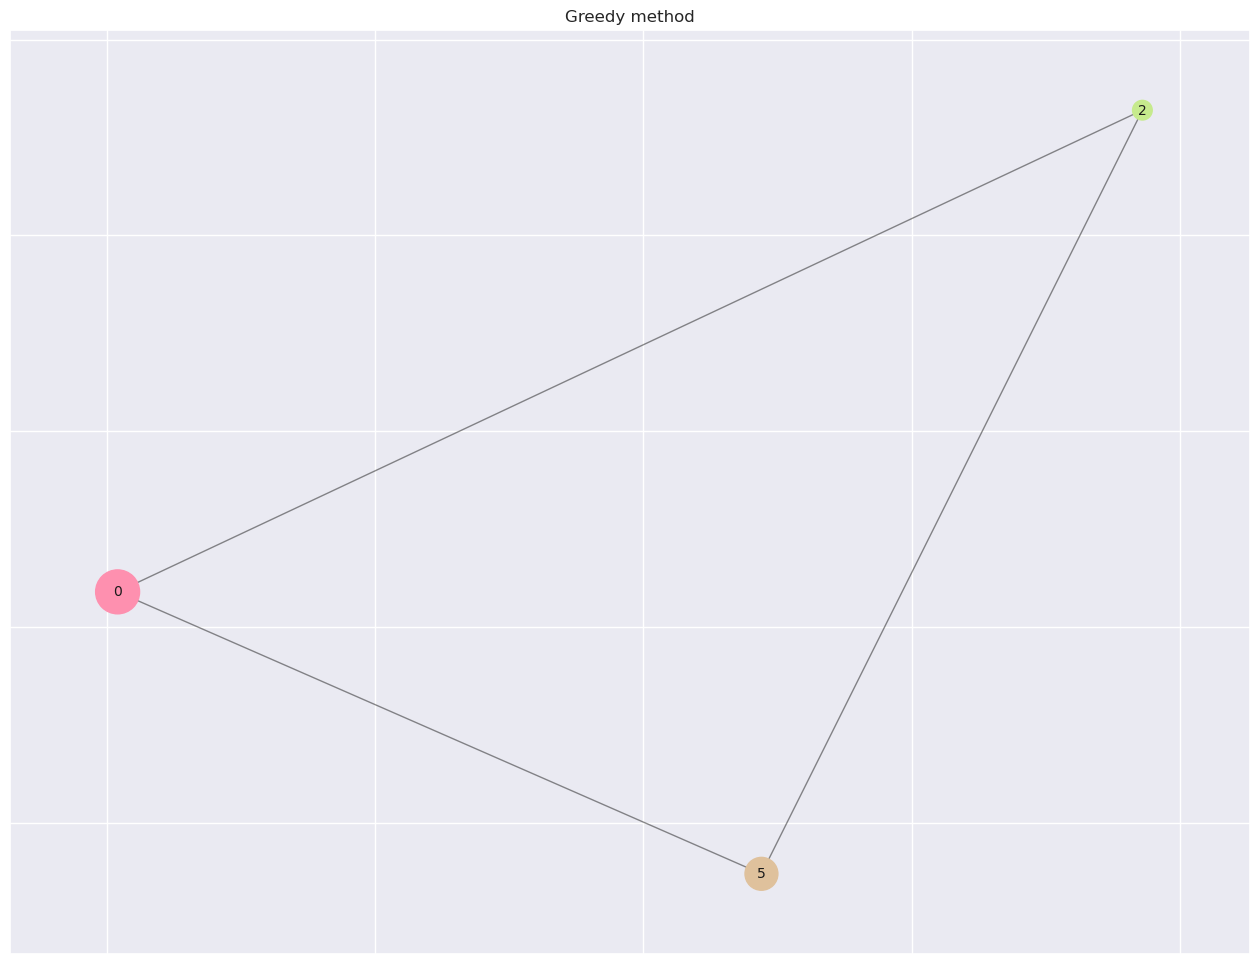


Distance matrix:


array([[  0, 458, 227,  50, 529, 140, 617],
       [458,   0, 252, 509, 167, 375, 178],
       [227, 252,   0, 274, 368, 208, 426],
       [ 50, 509, 274,   0, 578, 182, 667],
       [529, 167, 368, 578,   0, 411, 125],
       [140, 375, 208, 182, 411,   0, 512],
       [617, 178, 426, 667, 125, 512,   0]])


Costs:


array([476, 193,  34, 921, 297, 233, 609])


Selected nodes:
0 -> 2, 5
2 -> 0, 5
5 -> 0, 2
####
Edges:
----
0 2
----
0 5
----
2 5
Anchors 0, 2 => 1 distance 676 Curr min: inf node None Curr selected: [0, 2]
Anchors 0, 5 => 1 distance 886 Curr min: 676 node 1 Curr selected: [0, 2]
Anchors 2, 5 => 1 distance 612 Curr min: 676 node 1 Curr selected: [0, 2]
Anchors 0, 2 => 3 distance 1018 Curr min: 612 node 1 Curr selected: [2, 5]
Anchors 0, 5 => 3 distance 1013 Curr min: 612 node 1 Curr selected: [2, 5]
Anchors 2, 5 => 3 distance 1169 Curr min: 612 node 1 Curr selected: [2, 5]
Anchors 0, 2 => 4 distance 967 Curr min: 612 node 1 Curr selected: [2, 5]
Anchors 0, 5 => 4 distance 1097 Curr min: 612 node 1 Curr selected: [2, 5]
Anchors 2, 5 => 4 distance 868 Curr min: 612 node 1 Curr selected: [2, 5]
Anchors 0, 2 => 6 distance 1425 Curr min: 612 node 1 Curr selected: [2, 5]
Anchors 0, 5 => 6 distance 1598 Curr min: 612 node 1 Curr selected: [2, 5]
Anchors 2, 5 => 6 distance 1339 Curr min: 612 node 1 Curr selected: [2, 5]
Selected anchors

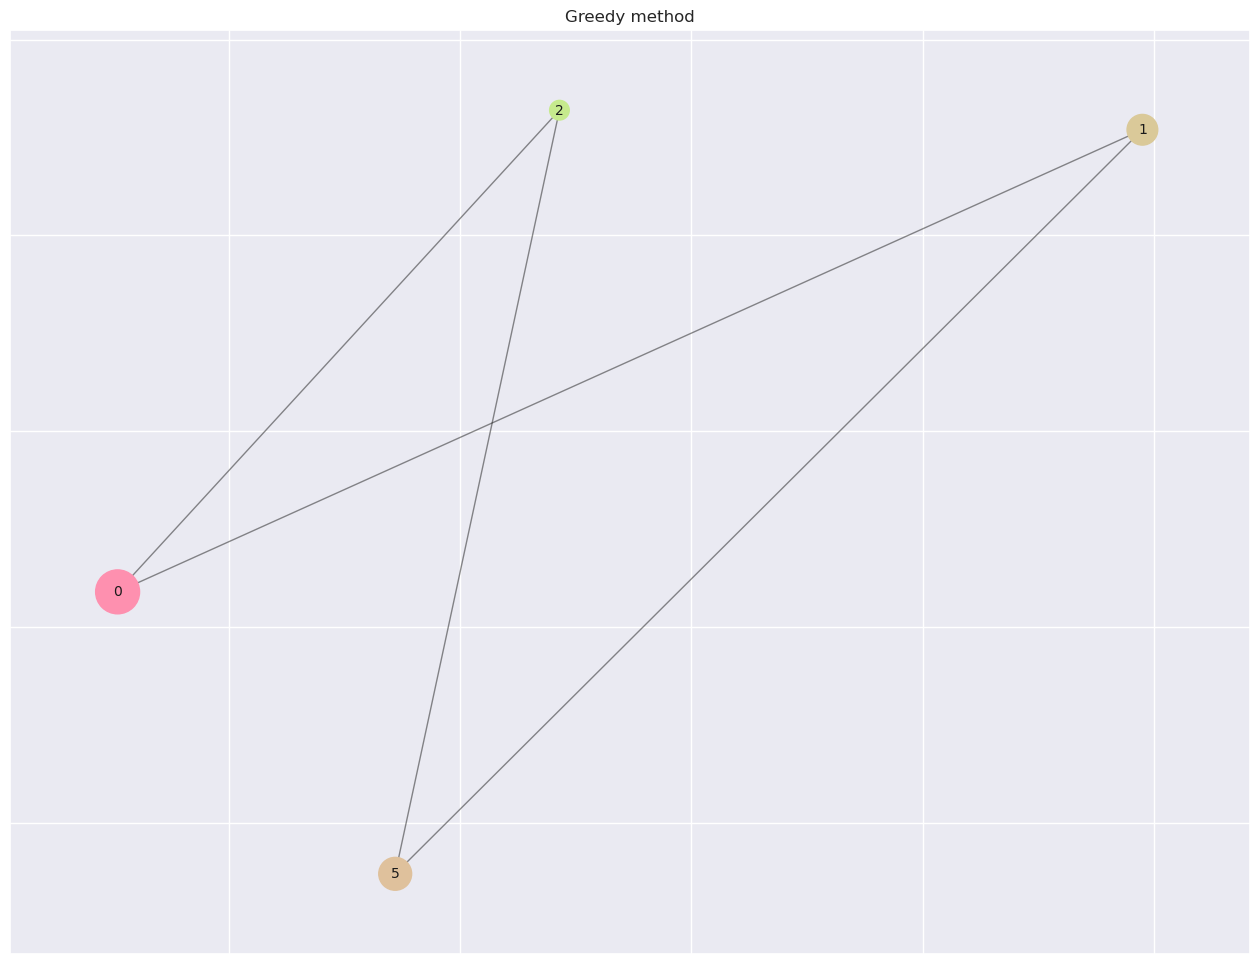


Distance matrix:


array([[  0, 458, 227,  50, 529, 140, 617],
       [458,   0, 252, 509, 167, 375, 178],
       [227, 252,   0, 274, 368, 208, 426],
       [ 50, 509, 274,   0, 578, 182, 667],
       [529, 167, 368, 578,   0, 411, 125],
       [140, 375, 208, 182, 411,   0, 512],
       [617, 178, 426, 667, 125, 512,   0]])


Costs:


array([476, 193,  34, 921, 297, 233, 609])


Selected nodes:
0 -> 2, 5
2 -> 0, 1
5 -> 0, 1
1 -> 2, 5
####
Edges:
----
0 2
----
0 5
----
2 1
----
5 1
Anchors 0, 2 => 3 distance 1018 Curr min: inf node None Curr selected: [2, 5]
Anchors 0, 5 => 3 distance 1013 Curr min: 1018 node 3 Curr selected: [0, 2]
Anchors 2, 1 => 3 distance 1452 Curr min: 1013 node 3 Curr selected: [0, 5]
Anchors 5, 1 => 3 distance 1237 Curr min: 1013 node 3 Curr selected: [0, 5]
Anchors 0, 2 => 4 distance 967 Curr min: 1013 node 3 Curr selected: [0, 5]
Anchors 0, 5 => 4 distance 1097 Curr min: 967 node 4 Curr selected: [0, 2]
Anchors 2, 1 => 4 distance 580 Curr min: 967 node 4 Curr selected: [0, 2]
Anchors 5, 1 => 4 distance 500 Curr min: 580 node 4 Curr selected: [2, 1]
Anchors 0, 2 => 6 distance 1425 Curr min: 500 node 4 Curr selected: [5, 1]
Anchors 0, 5 => 6 distance 1598 Curr min: 500 node 4 Curr selected: [5, 1]
Anchors 2, 1 => 6 distance 961 Curr min: 500 node 4 Curr selected: [5, 1]
Anchors 5, 1 => 6 distance 924 Curr min: 500 node 4 Curr selected: 

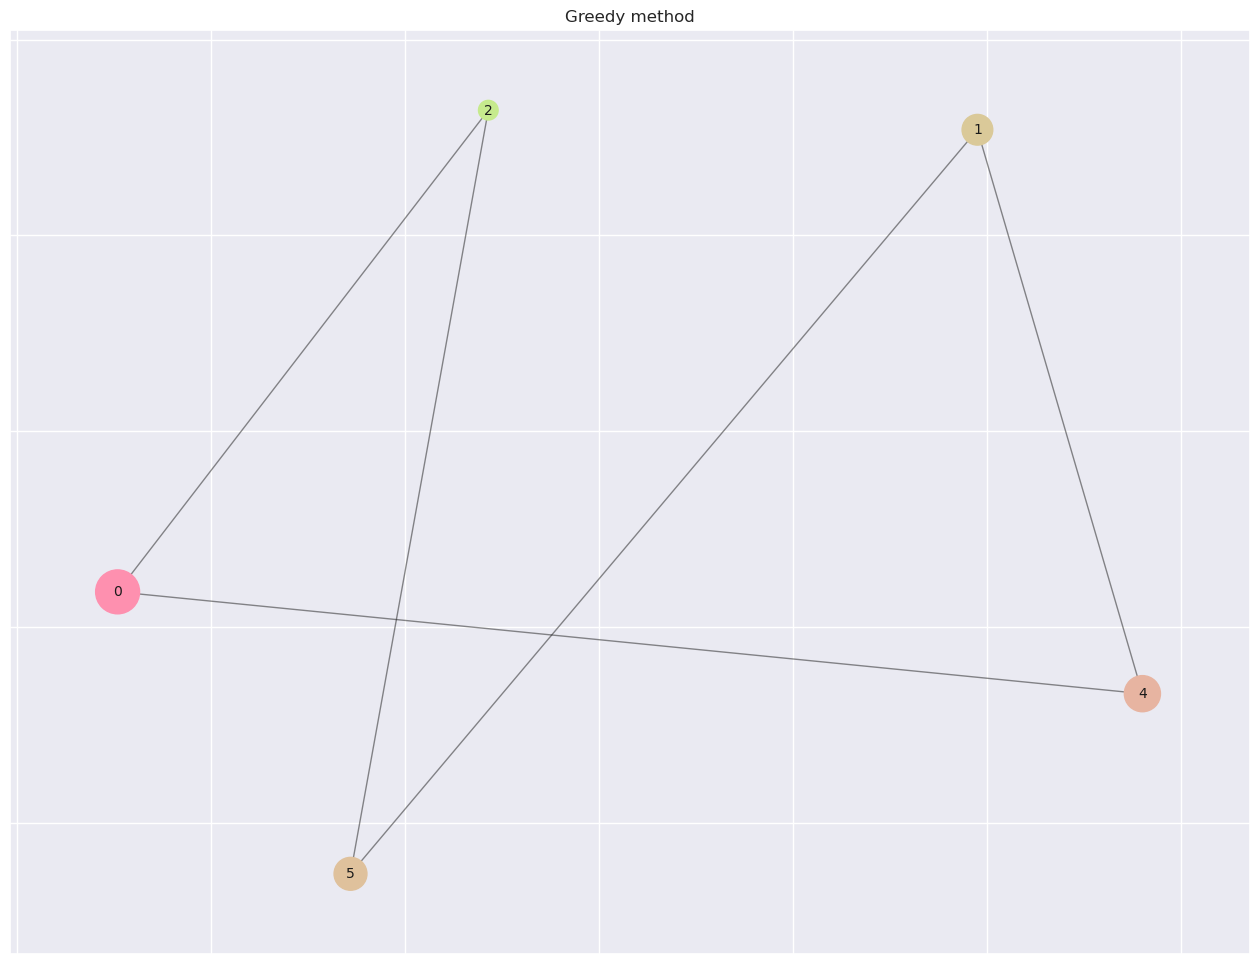


Distance matrix:


array([[  0, 458, 227,  50, 529, 140, 617],
       [458,   0, 252, 509, 167, 375, 178],
       [227, 252,   0, 274, 368, 208, 426],
       [ 50, 509, 274,   0, 578, 182, 667],
       [529, 167, 368, 578,   0, 411, 125],
       [140, 375, 208, 182, 411,   0, 512],
       [617, 178, 426, 667, 125, 512,   0]])


Costs:


array([476, 193,  34, 921, 297, 233, 609])


Selected nodes:
0 -> 2, 5
2 -> 0, 1
5 -> 0, 4
1 -> 2, 4
4 -> 5, 1
####
Edges:
----
0 2
----
0 5
----
2 1
----
5 4
----
1 4
Anchors 0, 2 => 3 distance 1018 Curr min: inf node None Curr selected: [5, 1]
Anchors 0, 5 => 3 distance 1013 Curr min: 1018 node 3 Curr selected: [0, 2]
Anchors 2, 1 => 3 distance 1452 Curr min: 1013 node 3 Curr selected: [0, 5]
Anchors 5, 4 => 3 distance 1270 Curr min: 1013 node 3 Curr selected: [0, 5]
Anchors 1, 4 => 3 distance 1841 Curr min: 1013 node 3 Curr selected: [0, 5]
Anchors 0, 2 => 6 distance 1425 Curr min: 1013 node 3 Curr selected: [0, 5]
Anchors 0, 5 => 6 distance 1598 Curr min: 1013 node 3 Curr selected: [0, 5]
Anchors 2, 1 => 6 distance 961 Curr min: 1013 node 3 Curr selected: [0, 5]
Anchors 5, 4 => 6 distance 835 Curr min: 961 node 6 Curr selected: [2, 1]
Anchors 1, 4 => 6 distance 745 Curr min: 835 node 6 Curr selected: [5, 4]
Selected anchors: 1, 4; node: 6
0 -> 2, 5
2 -> 0, 1
5 -> 0, 4
1 -> 2, 6
4 -> 5, 6
6 -> 1, 4


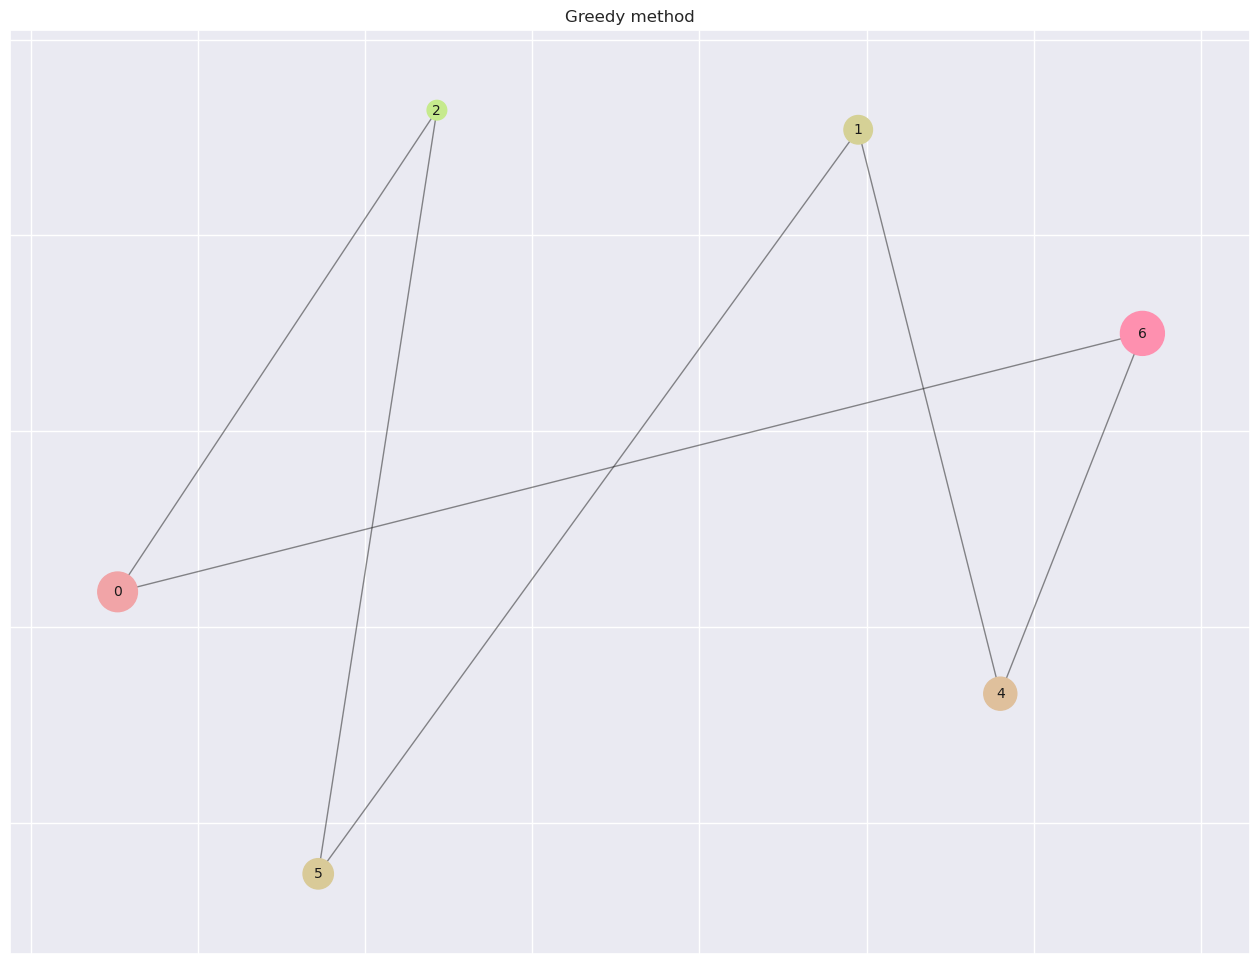


Distance matrix:


array([[  0, 458, 227,  50, 529, 140, 617],
       [458,   0, 252, 509, 167, 375, 178],
       [227, 252,   0, 274, 368, 208, 426],
       [ 50, 509, 274,   0, 578, 182, 667],
       [529, 167, 368, 578,   0, 411, 125],
       [140, 375, 208, 182, 411,   0, 512],
       [617, 178, 426, 667, 125, 512,   0]])


Costs:


array([476, 193,  34, 921, 297, 233, 609])


Selected nodes:
0 -> 2, 5
2 -> 0, 1
5 -> 0, 4
1 -> 2, 6
4 -> 5, 6
6 -> 1, 4
####
Edges:
----
0 2
----
0 5
----
2 1
----
5 4
----
1 6
----
4 6
Anchors 0, 2 => 3 distance 1018 Curr min: inf node None Curr selected: [1, 4]
Anchors 0, 5 => 3 distance 1013 Curr min: 1018 node 3 Curr selected: [0, 2]
Anchors 2, 1 => 3 distance 1452 Curr min: 1013 node 3 Curr selected: [0, 5]
Anchors 5, 4 => 3 distance 1270 Curr min: 1013 node 3 Curr selected: [0, 5]
Anchors 1, 6 => 3 distance 1919 Curr min: 1013 node 3 Curr selected: [0, 5]
Anchors 4, 6 => 3 distance 2041 Curr min: 1013 node 3 Curr selected: [0, 5]
Selected anchors: 0, 5; node: 3
0 -> 2, 3
2 -> 0, 1
5 -> 4, 3
1 -> 2, 6
4 -> 5, 6
6 -> 1, 4
3 -> 0, 5


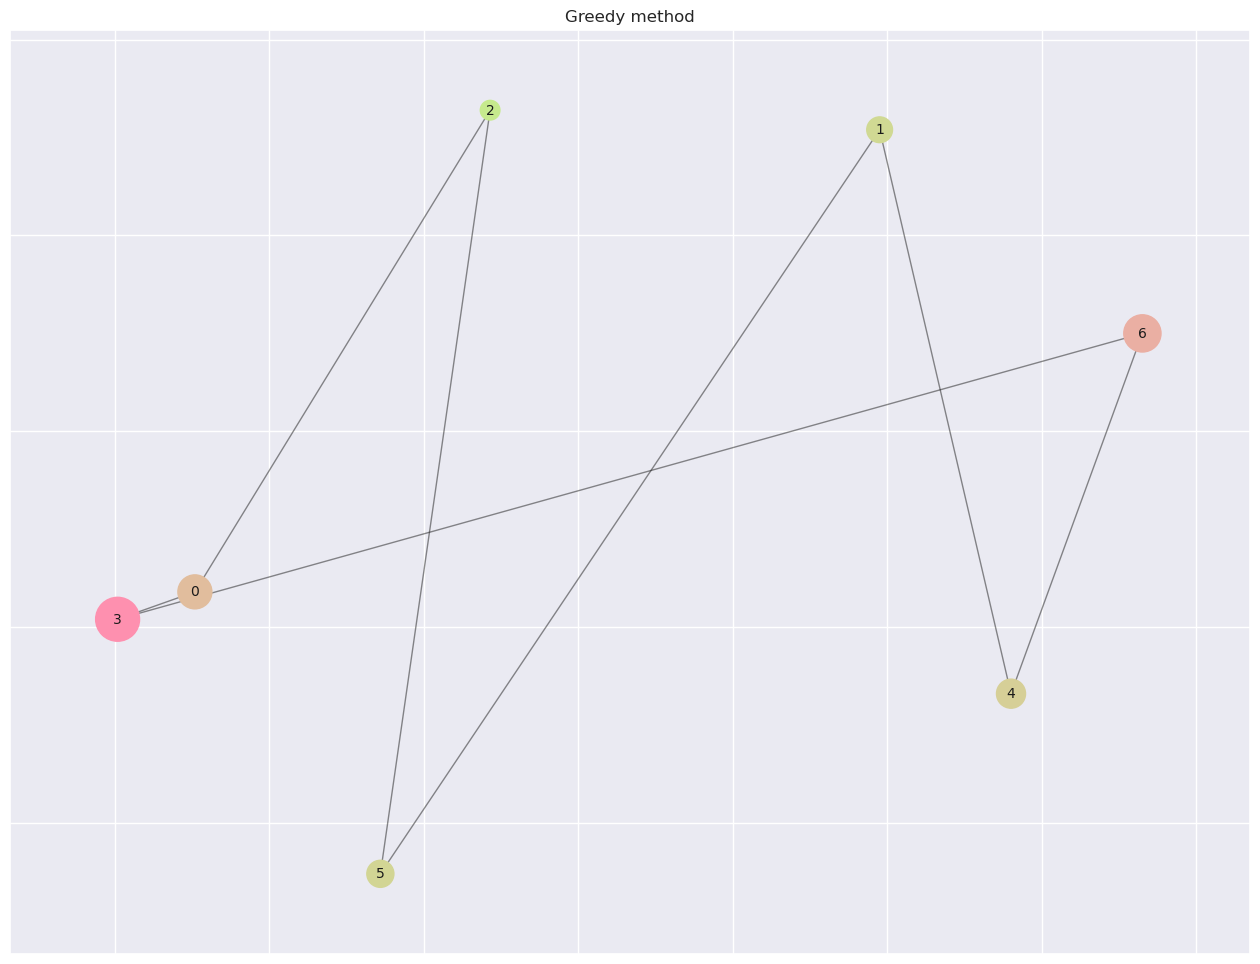

Finished greedy method in 0.66s


In [183]:
grades: dict[str, Grade] = {}
no_runs = len(nodes)
no_runs = 1

for method in [greedy]:  #random, nearest, 
    method_name = method.__name__
    print(f"Running {method_name} method for {no_runs} runs")
    start = perf_counter()
    grades[method_name] = grade_method(nodes, method, no_runs)
    print(f"Finished {method_name} method in {perf_counter() - start:.2f}s")

In [184]:
for method_name, grade in grades.items():
    print(grade)


==================================== Grade =====================================
Method:                                 greedy
Best run id:                            0
Best run cost:                          2763
Best run distance:                      1819
Best run score:                         4582
Min score:                              4582
Avg score:                              4582
Max score:                              4582



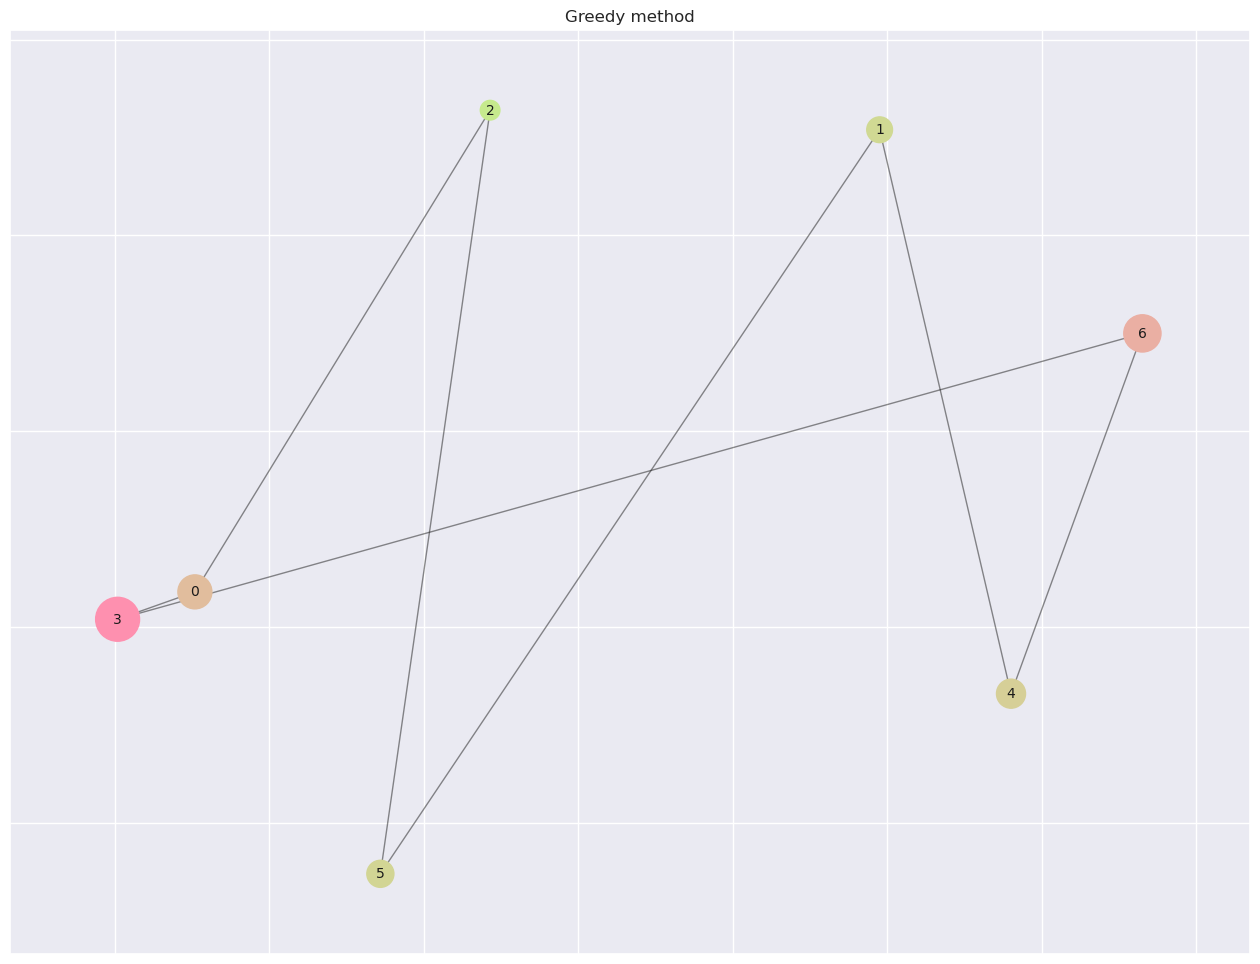

In [185]:
for method_name, grade in grades.items():
    visualise_solution(grade.best_run.nodes, method_name)

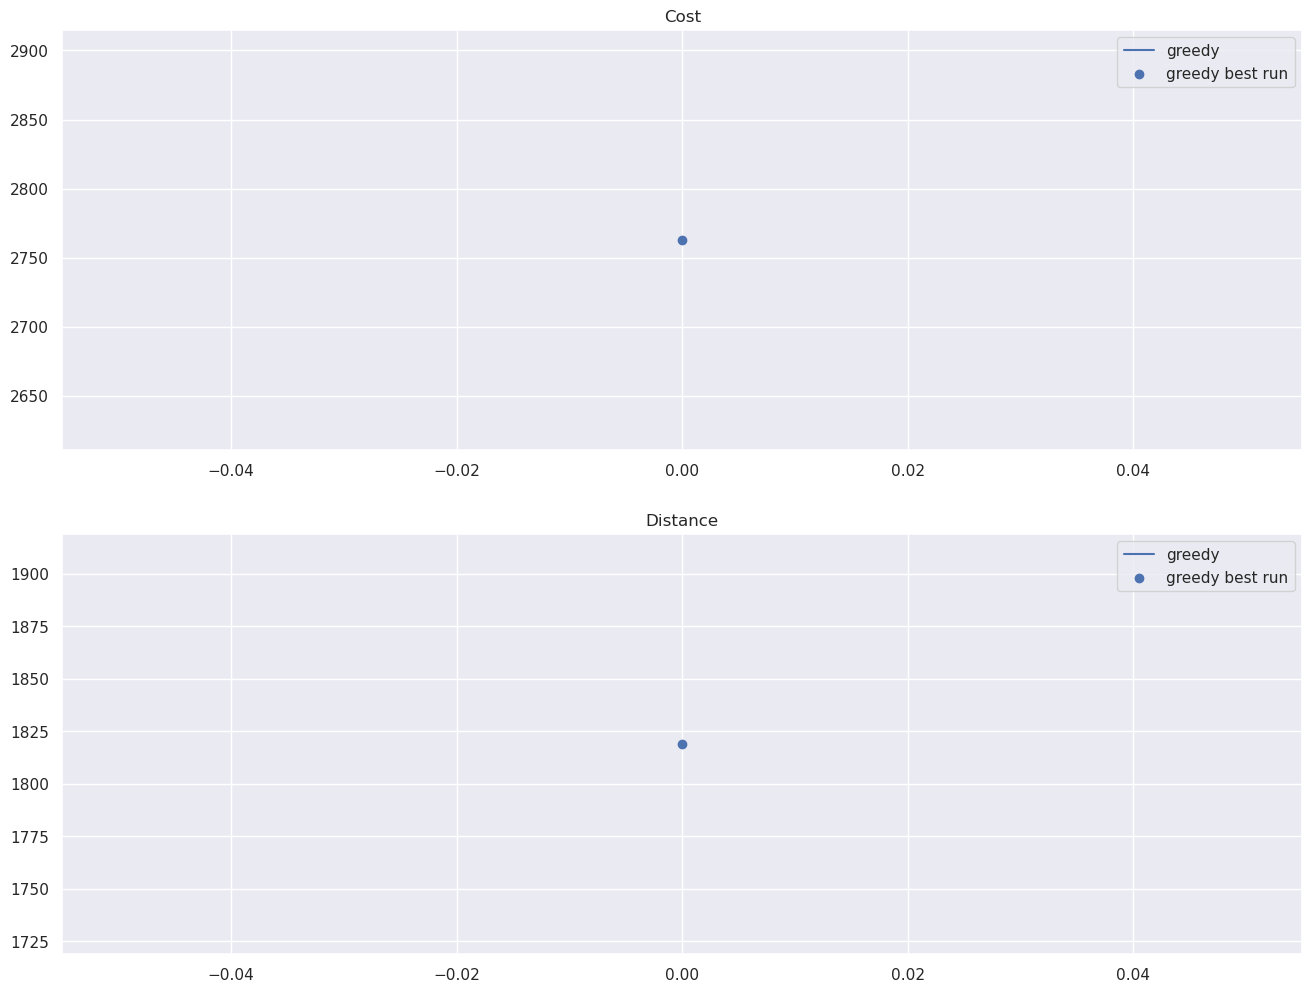

In [186]:
fig, (ax1, ax2) = plt.subplots(2, 1)

for method_name, grade in grades.items():
    ax1.plot([run.id for run in grade.runs], [run.cost for run in grade.runs], label=method_name)
    ax2.plot([run.id for run in grade.runs], [run.distance for run in grade.runs], label=method_name)

    ax1.scatter(grade.best_run.id, grade.best_run.cost, color=ax1.lines[-1].get_color(), label=f"{method_name} best run")
    ax2.scatter(grade.best_run.id, grade.best_run.distance, color=ax2.lines[-1].get_color(), label=f"{method_name} best run")

ax1.set_title("Cost")
ax2.set_title("Distance")

ax1.legend()
ax2.legend()

plt.show()


In [187]:
raise

RuntimeError: No active exception to reraise

# Dataset TSPB

In [ ]:
nodes = [Node(i, x, y, cost) for i, (x, y, cost) in enumerate(zip(df_b.x, df_b.y, df_b.cost))]

In [ ]:
# Check if the nodes are unique
len(set(nodes)) == len(nodes)

In [ ]:
distance_matrix = _get_distance_matrix(nodes)

In [ ]:
grades: dict[str, Grade] = {}
no_runs = len(nodes)
no_runs = 200

for method in [random, nearest, greedy]:
    method_name = method.__name__
    print(f"Running {method_name} method for {no_runs} runs")
    start = perf_counter()
    grades[method_name] = grade_method(nodes, method, no_runs)
    print(f"Finished {method_name} method in {perf_counter() - start:.2f}s")

In [ ]:
for method_name, grade in grades.items():
    print(grade)

In [ ]:
for method_name, grade in grades.items():
    visualise_solution(grade.best_run.nodes, method_name)

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1)

for method_name, grade in grades.items():
    ax1.plot([run.id for run in grade.runs], [run.cost for run in grade.runs], label=method_name)
    ax2.plot([run.id for run in grade.runs], [run.distance for run in grade.runs], label=method_name)

    ax1.scatter(grade.best_run.id, grade.best_run.cost, color=ax1.lines[-1].get_color(), label=f"{method_name} best run")
    ax2.scatter(grade.best_run.id, grade.best_run.distance, color=ax2.lines[-1].get_color(), label=f"{method_name} best run")

ax1.set_title("Cost")
ax2.set_title("Distance")

ax1.legend()
ax2.legend()

plt.show()
